In [39]:
import numpy as np
import astropy.io.fits as pf
import pylab as mplot
%pylab inline

import os
import treecorr
import h5py
import healpy as hp

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/chihway/.conda/envs/shear_decade/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [40]:
# psf_files = os.listdir('/project/chihway/data/decade/psf_cats')
psf_files = os.listdir('/project2/chihway/secco/PSFs/Nov2022/r')
Npatch = 100

In [41]:
# !!! Need to add other bands for the PSF !!!

In [42]:
T = []
T_mod = []
e1 = []
e1_mod = []
e2 = []
e2_mod = []
ra = []
dec = []
snr = []


for ff in psf_files:
    infile = pf.open('/project2/chihway/secco/PSFs/Nov2022/r/'+ff)[1].data
    mask = (infile['IMAFLAGS_ISO']==0)
    T.append(infile['T_star_hsm'][mask])
    T_mod.append(infile['T_model_hsm'][mask])
    e1.append(infile['g1_star_hsm'][mask])
    e1_mod.append(infile['g1_model_hsm'][mask])
    e2.append(infile['g2_star_hsm'][mask])
    e2_mod.append(infile['g2_model_hsm'][mask])
    ra.append(infile['ra'][mask])
    dec.append(infile['dec'][mask])
    snr.append(infile['FLUX_APER_8'][mask]/infile['FLUXERR_APER_8'][mask])
    

/tmp/ipykernel_17478/840614605.py:23: RuntimeWarning: invalid value encountered in true_divide
  snr.append(infile['FLUX_APER_8'][mask]/infile['FLUXERR_APER_8'][mask])


In [43]:
T = np.hstack(np.array(T))
T_mod = np.hstack(np.array(T_mod))
e1 = np.hstack(np.array(e1))
e1_mod = np.hstack(np.array(e1_mod))
e2 = np.hstack(np.array(e2))
e2_mod = np.hstack(np.array(e2_mod))
ra = np.hstack(np.array(ra))
dec = np.hstack(np.array(dec))
snr = np.hstack(np.array(snr))

/tmp/ipykernel_17478/3551877762.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  T = np.hstack(np.array(T))
/tmp/ipykernel_17478/3551877762.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  T_mod = np.hstack(np.array(T_mod))
/tmp/ipykernel_17478/3551877762.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  e1 = np.hstack(np.ar

In [44]:
d_e1_psf = e1-e1_mod
d_e2_psf = e2-e2_mod
d_T1_psf = e1*(T-T_mod)/T
d_T2_psf = e2*(T-T_mod)/T


d_e1_psf = np.nan_to_num(d_e1_psf)
d_e2_psf = np.nan_to_num(d_e2_psf)
d_T1_psf = np.nan_to_num(d_T1_psf)
d_T2_psf = np.nan_to_num(d_T2_psf)

mask = (d_e1_psf!=0)*(d_e2_psf!=0)*(d_T1_psf!=0)*(d_T2_psf!=0)*(snr>40) # switch on or off this *(snr>40)

d_e1_psf = d_e1_psf[mask]
d_e2_psf = d_e2_psf[mask]
ra_psf = ra[mask]
dec_psf = dec[mask]
snr_psf = snr[mask]
e1_star = e1[mask]
e2_star = e2[mask]
e1_psf = e1_mod[mask]
e2_psf = e2_mod[mask]
w1 = d_T1_psf[mask]
w2 = d_T1_psf[mask]

In [45]:
with h5py.File('/project2/chihway/data/decade/metacal_test_1000tiles_20221108_all.hdf') as f:

    mask0 = (~((f['DATA/mcal_T_noshear'][:]>2)*(f['DATA/mcal_s2n_noshear'][:]<30)))*(f['DATA/mcal_T_noshear'][:]<10)*(f['DATA/mcal_s2n_noshear'][:]<1000)*(f['DATA/mcal_s2n_noshear'][:]>10)*(f['DATA/mcal_T_ratio_noshear'][:]>0.5)

    ra_gal = f['DATA/ra'][mask0]
    dec_gal = f['DATA/dec'][mask0]
    g1_gal = f['DATA/mcal_g_noshear'][:,0][mask0]/0.71 # average calibration
    g2_gal = f['DATA/mcal_g_noshear'][:,1][mask0]/0.71
    

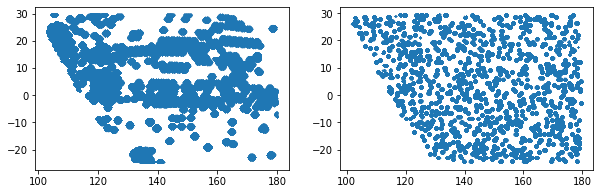

In [46]:
mplot.figure(figsize=(10,3))
mplot.subplot(121)
mplot.scatter(ra_psf,dec_psf, marker='.', s=0.1)
mplot.subplot(122)
mplot.scatter(ra_gal,dec_gal, marker='.', s=0.1)

In [47]:
mask_psf = np.zeros(hp.nside2npix(1024))
mask_gal = np.zeros(hp.nside2npix(1024))

pix_psf = hp.ang2pix(1024, (90.-dec_psf)/180*np.pi, ra_psf/180*np.pi)
pix_gal = hp.ang2pix(1024, (90.-dec_gal)/180*np.pi, ra_gal/180*np.pi)

pix_id_psf = np.argsort(pix_psf)
pix_id_gal = np.argsort(pix_gal)

pix_psf_sort = pix_psf[pix_id_psf]
d_e1_psf = d_e1_psf[pix_id_psf]
d_e2_psf = d_e2_psf[pix_id_psf]
ra_psf = ra_psf[pix_id_psf]
dec_psf = dec_psf[pix_id_psf]
snr_psf = snr_psf[pix_id_psf]
e1_star = e1_star[pix_id_psf]
e2_star = e2_star[pix_id_psf]
e1_psf = e1_psf[pix_id_psf]
e2_psf = e2_psf[pix_id_psf]
w1 = w1[pix_id_psf]
w2 = w2[pix_id_psf]


pix_gal_sort = pix_gal[pix_id_gal]
ra_gal = ra_gal[pix_id_gal]
dec_gal = dec_gal[pix_id_gal]
g1_gal = g1_gal[pix_id_gal]
g2_gal = g2_gal[pix_id_gal]

mask_psf[pix_psf_sort] = 1
mask_gal[pix_gal_sort] = 1


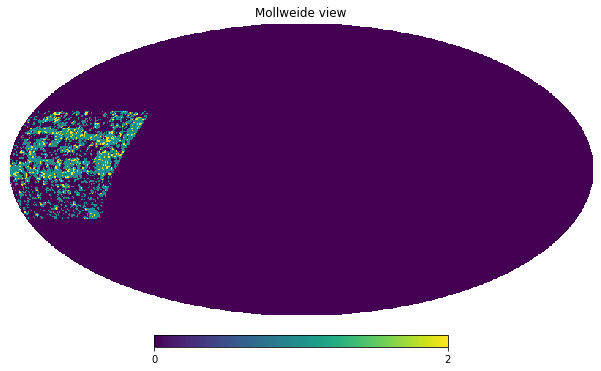

In [48]:
hp.mollview(mask_psf+mask_gal)

226.02571284432918


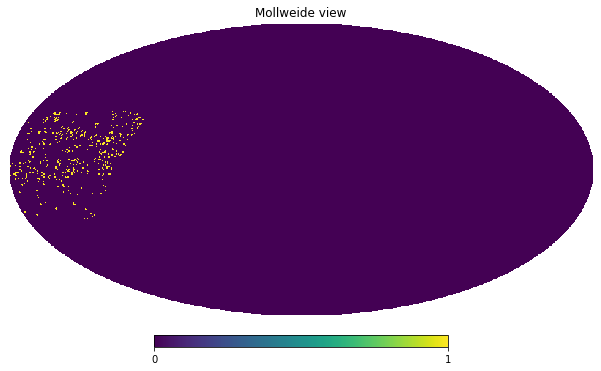

In [49]:
mask_psf_gal = mask_psf*mask_gal
hp.mollview(mask_psf_gal)
print(np.sum(mask_psf_gal)/hp.nside2npix(1024)*4*np.pi*(180/np.pi)**2)

pix_both = np.arange(hp.nside2npix(1024))[mask_psf_gal.astype('bool')]

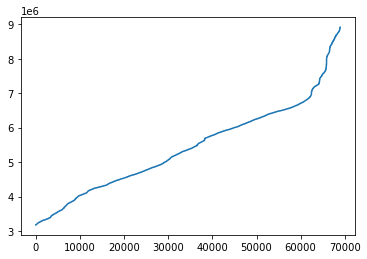

In [50]:
mplot.plot(pix_both)

In [51]:
# mask everything to the joint mask

psf_in_mask = np.in1d(pix_psf_sort, pix_both)
gal_in_mask = np.in1d(pix_gal_sort, pix_both)

d_e1_psf = d_e1_psf[psf_in_mask]
d_e2_psf = d_e2_psf[psf_in_mask]
snr_psf = snr_psf[psf_in_mask]
e1_star = e1_star[psf_in_mask]
e2_star = e2_star[psf_in_mask]
e1_psf = e1_psf[psf_in_mask]
e2_psf = e2_psf[psf_in_mask]
w1 = w1[psf_in_mask]
w2 = w2[psf_in_mask]
ra_psf = ra_psf[psf_in_mask]
dec_psf = dec_psf[psf_in_mask]

ra_gal = ra_gal[gal_in_mask]
dec_gal = dec_gal[gal_in_mask]
g1_gal = g1_gal[gal_in_mask]
g2_gal = g2_gal[gal_in_mask]

In [52]:
g1_gal

array([ 0.54874897, -0.00870524,  0.15971041, ...,  0.3045457 ,
        0.02243809, -0.02773031])

In [53]:
# cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, ra_units='degrees', dec_units='degrees', g1=g1_gal, g2=g2_gal, npatch=100)

# cat_p_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf, patch_centers=cat_gal.patch_centers)
# cat_q_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf, patch_centers=cat_gal.patch_centers)
# cat_w_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_T1_psf, g2=d_T2_psf, patch_centers=cat_gal.patch_centers)


In [54]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf, npatch=Npatch)
cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, ra_units='degrees', dec_units='degrees', g1=g1_gal, g2=g2_gal, patch_centers=cat_psf.patch_centers)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf, cat_gal)
theta = np.exp(gg.meanlogr)

tau2p = gg.xip
tau2m = gg.xim
tau2_cov = gg.estimate_cov('bootstrap')
tau2p_err = np.diag(tau2_cov)[:20]**0.5 #gg.varxip**0.5
tau2m_err = np.diag(tau2_cov)[20:]**0.5 #gg.varxim**0.5


The following patch numbers have no objects: {24}
This may be a problem depending on your use case.
The following patch numbers have no objects: {24}
This may be a problem depending on your use case.


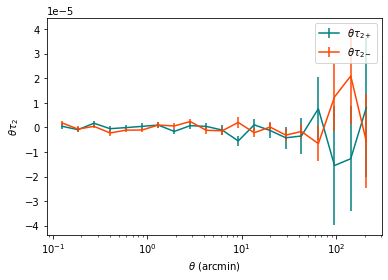

In [55]:
mplot.errorbar(theta, theta*tau2p, theta*tau2p_err, color='teal', label='$\\theta \\tau_{2+}$')
mplot.errorbar(theta, theta*tau2m, theta*tau2m_err, color='orangered', label='$\\theta \\tau_{2-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\tau_{2}$')
mplot.legend()

In [56]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf, npatch=Npatch)
cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, ra_units='degrees', dec_units='degrees', g1=g1_gal, g2=g2_gal, patch_centers=cat_psf.patch_centers)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf, cat_gal)
theta = np.exp(gg.meanlogr)

tau0p = gg.xip
tau0m = gg.xim
tau0_cov = gg.estimate_cov('bootstrap')
tau0p_err = np.diag(tau0_cov)[:20]**0.5 #gg.varxip**0.5
tau0m_err = np.diag(tau0_cov)[20:]**0.5 #gg.varxim**0.5


The following patch numbers have no objects: {23}
This may be a problem depending on your use case.
The following patch numbers have no objects: {23}
This may be a problem depending on your use case.


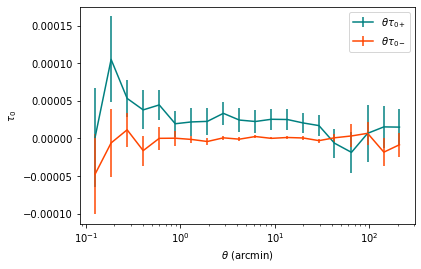

In [57]:
mplot.errorbar(theta, tau0p, tau0p_err, color='teal', label='$\\theta \\tau_{0+}$')
mplot.errorbar(theta, tau0m, tau0m_err, color='orangered', label='$\\theta \\tau_{0-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ \\tau_{0}$')
mplot.legend()

In [58]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2, npatch=Npatch)
cat_gal = treecorr.Catalog(ra=ra_gal, dec=dec_gal, ra_units='degrees', dec_units='degrees', g1=g1_gal, g2=g2_gal, patch_centers=cat_psf.patch_centers)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf, cat_gal)
theta = np.exp(gg.meanlogr)

tau5p = gg.xip
tau5m = gg.xim
tau5_cov = gg.estimate_cov('bootstrap')
tau5p_err = np.diag(tau5_cov)[:20]**0.5 #gg.varxip**0.5
tau5m_err = np.diag(tau5_cov)[20:]**0.5 #gg.varxim**0.5


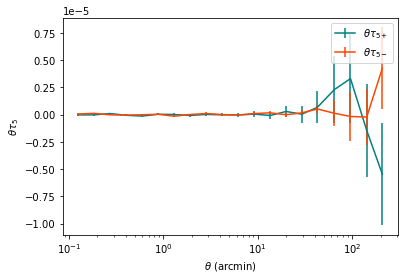

In [59]:
mplot.errorbar(theta, theta*tau5p, theta*tau5p_err, color='teal', label='$\\theta \\tau_{5+}$')
mplot.errorbar(theta, theta*tau5m, theta*tau5m_err, color='orangered', label='$\\theta \\tau_{5-}$')

mplot.xscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$\\theta \\tau_{5}$')
mplot.legend()

## Also calculate the rho stats to get alpha beta gamma

In [60]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf, npatch=Npatch)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf)
theta = np.exp(gg.meanlogr)

rho0p = gg.xip
rho0m = gg.xim
rho0_cov = gg.estimate_cov('bootstrap')
rho0p_err = np.diag(rho0_cov[:20,:20])**0.5
rho0m_err = np.diag(rho0_cov[20:,20:])**0.5


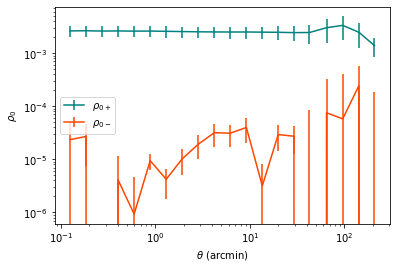

In [61]:
mplot.errorbar(theta, rho0p, rho0p_err, color='teal', label='$ \\rho_{0+}$')
mplot.errorbar(theta, rho0m, rho0m_err, color='orangered', label='$ \\rho_{0-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ \\rho_{0}$')
mplot.legend()

In [62]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf, npatch=Npatch)
gg = treecorr.GGCorrelation(min_sep=0.05, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf)
theta = np.exp(gg.meanlogr)

rho1p = gg.xip
rho1m = gg.xim
rho1_cov = gg.estimate_cov('bootstrap')
rho1p_err = np.diag(rho1_cov[:20,:20])**0.5
rho1m_err = np.diag(rho1_cov[20:,20:])**0.5


The following patch numbers have no objects: {22}
This may be a problem depending on your use case.


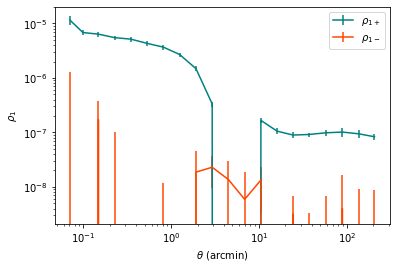

In [63]:
mplot.errorbar(theta, rho1p, rho1p_err, color='teal', label='$ \\rho_{1+}$')
mplot.errorbar(theta, rho1m, rho1m_err, color='orangered', label='$ \\rho_{1-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ \\rho_{1}$')
mplot.legend()

In [64]:
cat_psf1 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf, npatch=Npatch)
cat_psf2 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf, patch_centers=cat_psf1.patch_centers)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf1, cat_psf2)
theta = np.exp(gg.meanlogr)

rho2p = gg.xip
rho2m = gg.xim
rho2_cov = gg.estimate_cov('bootstrap')
rho2p_err = np.diag(rho2_cov[:20,:20])**0.5
rho2m_err = np.diag(rho2_cov[20:,20:])**0.5


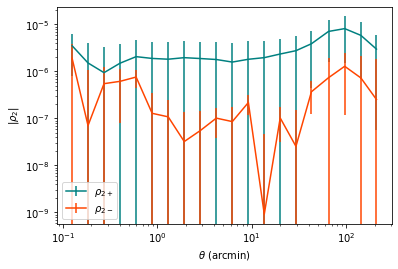

In [65]:
mplot.errorbar(theta, np.abs(rho2p), rho2p_err, color='teal', label='$ \\rho_{2+}$')
mplot.errorbar(theta, np.abs(rho2m), rho2m_err, color='orangered', label='$ \\rho_{2-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ |\\rho_{2}|$')
mplot.legend()

In [66]:
cat_psf = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2, npatch=Npatch)
gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf)
theta = np.exp(gg.meanlogr)

rho3p = gg.xip
rho3m = gg.xim
rho3_cov = gg.estimate_cov('bootstrap')

rho3p_err = np.diag(rho3_cov[:20,:20])**0.5
rho3m_err = np.diag(rho3_cov[20:,20:])**0.5


The following patch numbers have no objects: {23}
This may be a problem depending on your use case.


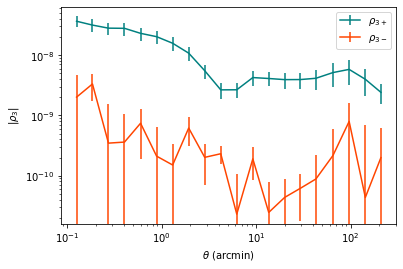

In [67]:
mplot.errorbar(theta, np.abs(rho3p), rho3p_err, color='teal', label='$ \\rho_{3+}$')
mplot.errorbar(theta, np.abs(rho3m), rho3m_err, color='orangered', label='$\\rho_{3-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ |\\rho_{3}|$')
mplot.legend()

In [68]:
cat_psf1 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=d_e1_psf, g2=d_e2_psf, npatch=Npatch)
cat_psf2 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2, patch_centers=cat_psf1.patch_centers)

gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf1, cat_psf2)
theta = np.exp(gg.meanlogr)

rho4p = gg.xip
rho4m = gg.xim
rho4_cov = gg.estimate_cov('bootstrap')
rho4p_err = np.diag(rho4_cov[:20,:20])**0.5
rho4m_err = np.diag(rho4_cov[20:,20:])**0.5


The following patch numbers have no objects: {22}
This may be a problem depending on your use case.
The following patch numbers have no objects: {22}
This may be a problem depending on your use case.


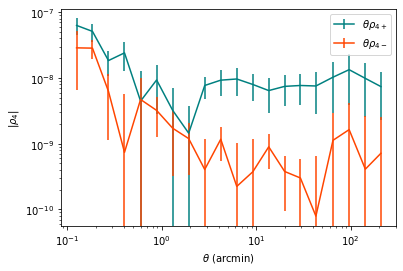

In [69]:
mplot.errorbar(theta, np.abs(rho4p), rho4p_err, color='teal', label='$\\theta \\rho_{4+}$')
mplot.errorbar(theta, np.abs(rho4m), rho4m_err, color='orangered', label='$\\theta \\rho_{4-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$|\\rho_{4}|$')
mplot.legend()

In [70]:
cat_psf1 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=e1_psf, g2=e2_psf, npatch=Npatch)
cat_psf2 = treecorr.Catalog(ra=ra_psf, dec=dec_psf, ra_units='degrees', dec_units='degrees', g1=w1, g2=w2, patch_centers=cat_psf1.patch_centers)

gg = treecorr.GGCorrelation(min_sep=0.1, max_sep=250., nbins=20, bin_slop=0.01, sep_units='arcmin') 
gg.process(cat_psf1, cat_psf2)
theta = np.exp(gg.meanlogr)

rho5p = gg.xip
rho5m = gg.xim
rho5_cov = gg.estimate_cov('bootstrap')
rho5p_err = np.diag(rho5_cov[:20,:20])**0.5
rho5m_err = np.diag(rho5_cov[20:,20:])**0.5


The following patch numbers have no objects: {23, 7}
This may be a problem depending on your use case.
The following patch numbers have no objects: {23, 7}
This may be a problem depending on your use case.


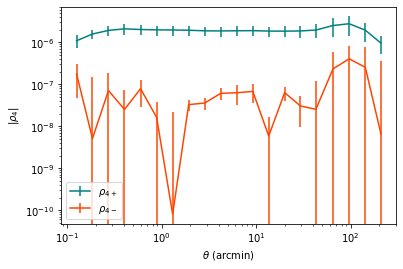

In [71]:
mplot.errorbar(theta, np.abs(rho5p), rho5p_err, color='teal', label='$ \\rho_{4+}$')
mplot.errorbar(theta, np.abs(rho5m), rho5m_err, color='orangered', label='$ \\rho_{4-}$')

mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('$\\theta$ (arcmin)')
mplot.ylabel('$ |\\rho_{4}|$')
mplot.legend()

In [72]:
Alpha = []
Beta = []
Gamma = []
for i in range(20):
    A = np.array([[rho0p[i], rho2p[i], rho5p[i]], [rho2p[i], rho1p[i], rho4p[i]],[rho5p[i], rho4p[i], rho3p[i]]])
    B = np.array([tau0p[i], tau2p[i], tau5p[i]])
    X = np.linalg.solve(A, B)
    Alpha.append(X[0])
    Beta.append(X[1])
    Gamma.append(X[2])
    

(array([2., 0., 1., 1., 0., 2., 5., 1., 1., 2., 2., 1., 0., 0., 0., 1., 0.,
        0., 0., 1.]),
 array([-0.00361809, -0.00142288,  0.00077233,  0.00296755,  0.00516276,
         0.00735797,  0.00955318,  0.01174839,  0.0139436 ,  0.01613881,
         0.01833402,  0.02052923,  0.02272444,  0.02491966,  0.02711487,
         0.02931008,  0.03150529,  0.0337005 ,  0.03589571,  0.03809092,
         0.04028613]),
 <BarContainer object of 20 artists>)

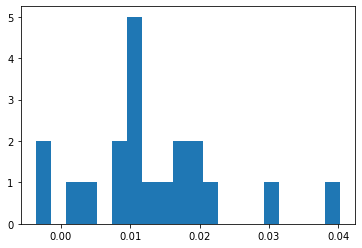

In [73]:
mplot.hist(Alpha, bins=20)

(array([2., 1., 0., 0., 3., 1., 3., 4., 1., 2., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 1.]),
 array([-1.76340602, -1.50827957, -1.25315311, -0.99802665, -0.7429002 ,
        -0.48777374, -0.23264729,  0.02247917,  0.27760563,  0.53273208,
         0.78785854,  1.042985  ,  1.29811145,  1.55323791,  1.80836437,
         2.06349082,  2.31861728,  2.57374374,  2.82887019,  3.08399665,
         3.3391231 ]),
 <BarContainer object of 20 artists>)

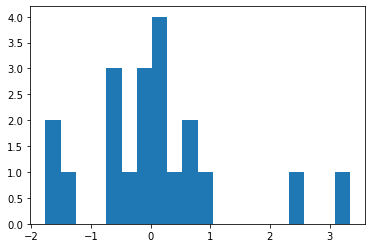

In [74]:
mplot.hist(Beta, bins=20)

(array([1., 1., 0., 0., 1., 2., 1., 0., 1., 2., 2., 0., 1., 0., 2., 1., 2.,
        0., 1., 2.]),
 array([-1.10567559e+01, -9.67300409e+00, -8.28925229e+00, -6.90550049e+00,
        -5.52174869e+00, -4.13799690e+00, -2.75424510e+00, -1.37049330e+00,
         1.32585011e-02,  1.39701030e+00,  2.78076210e+00,  4.16451390e+00,
         5.54826570e+00,  6.93201750e+00,  8.31576929e+00,  9.69952109e+00,
         1.10832729e+01,  1.24670247e+01,  1.38507765e+01,  1.52345283e+01,
         1.66182801e+01]),
 <BarContainer object of 20 artists>)

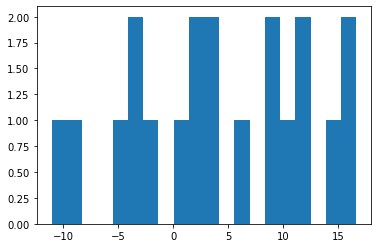

In [75]:
mplot.hist(Gamma, bins=20)

## Save everything

In [76]:
np.savez('Tau_Rho_SN80_Npatch_'+str(Npatch)+'.npz', theta=theta, rho0p=rho0p, rho0p_err=rho0p_err, rho0m=rho0m, rho0m_err=rho0m_err, rho0_cov=rho0_cov,
                                    rho1p=rho1p, rho1p_err=rho1p_err, rho1m=rho1m, rho1m_err=rho1m_err, rho1_cov=rho1_cov,
                                    rho2p=rho2p, rho2p_err=rho2p_err, rho2m=rho2m, rho2m_err=rho2m_err, rho2_cov=rho2_cov,
                                    rho3p=rho3p, rho3p_err=rho3p_err, rho3m=rho3m, rho3m_err=rho3m_err, rho3_cov=rho3_cov,
                                    rho4p=rho4p, rho4p_err=rho4p_err, rho4m=rho4m, rho4m_err=rho4m_err, rho4_cov=rho4_cov,
                                    rho5p=rho5p, rho5p_err=rho5p_err, rho5m=rho5m, rho5m_err=rho5m_err, rho5_cov=rho5_cov,
                                    tau0p=tau0p, tau0p_err=tau0p_err, tau0m=tau0m, tau0m_err=tau0m_err, tau0_cov=tau0_cov,
                                    tau2p=tau2p, tau2p_err=tau2p_err, tau2m=tau2m, tau2m_err=tau2m_err, tau2_cov=tau2_cov,
                                    tau5p=tau5p, tau5p_err=tau5p_err, tau5m=tau5m, tau5m_err=tau5m_err, tau5_cov=tau5_cov)

In [ ]:
# need to update the tau stats using full covariance!